# Hospital Readmissions Data Analysis and Recommendations for Reduction

### Background
In October 2012, the US government's Center for Medicare and Medicaid Services (CMS) began reducing Medicare payments for Inpatient Prospective Payment System hospitals with excess readmissions. Excess readmissions are measured by a ratio, by dividing a hospital’s number of “predicted” 30-day readmissions for heart attack, heart failure, and pneumonia by the number that would be “expected,” based on an average hospital with similar patients. A ratio greater than 1 indicates excess readmissions.


### Resources
+ Data source: https://data.medicare.gov/Hospital-Compare/Hospital-Readmission-Reduction/9n3s-kdb3
+ More information: http://www.cms.gov/Medicare/medicare-fee-for-service-payment/acuteinpatientPPS/readmissions-reduction-program.html
+ Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet
****

In [34]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import bokeh.plotting as bkp
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [106]:
# read in readmissions data provided
hospital_read_df = pd.read_csv('data/cms_hospital_readmissions.csv')
hospital_read_df.info()
hospital_read_df.head()
#hospital_read_df[hospital_read_df['Number of Readmissions'].isnull()]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 12 columns):
Hospital Name                 16860 non-null object
Provider Number               16860 non-null int64
State                         16860 non-null object
Measure Name                  16860 non-null object
Number of Discharges          16860 non-null object
Footnote                      3129 non-null float64
Excess Readmission Ratio      13731 non-null float64
Predicted Readmission Rate    13731 non-null float64
Expected Readmission Rate     13731 non-null float64
Number of Readmissions        11497 non-null float64
Start Date                    16860 non-null object
End Date                      16860 non-null object
dtypes: float64(5), int64(1), object(6)
memory usage: 1.5+ MB


,Hospital Name,Provider Number,State,Measure Name,Number of Discharges,Footnote,Excess Readmission Ratio,Predicted Readmission Rate,Expected Readmission Rate,Number of Readmissions,Start Date,End Date
0,FROEDTERT MEMORIAL LUTHERAN HOSPITAL,520177,WI,READM-30-HIP-KNEE-HRRP,242,NaN,1.9095,10.8,5.6,38.0,07/01/2010,06/30/2013
1,PROVIDENCE HOSPITAL,90006,DC,READM-30-HIP-KNEE-HRRP,247,NaN,1.7521,9.2,5.3,33.0,07/01/2010,06/30/2013
2,BEAUFORT COUNTY MEMORIAL HOSPITAL,420067,SC,READM-30-HIP-KNEE-HRRP,586,NaN,1.5836,7.6,4.8,53.0,07/01/2010,06/30/2013
3,ADVOCATE CHRIST HOSPITAL & MEDICAL CENTER,140208,IL,READM-30-HIP-KNEE-HRRP,965,NaN,1.5760,9.0,5.7,95.0,07/01/2010,06/30/2013
4,BRAZOSPORT REGIONAL HEALTH SYSTEM,450072,TX,READM-30-HIP-KNEE-HRRP,149,NaN,1.5308,8.2,5.4,20.0,07/01/2010,06/30/2013


Data Sample Date Range: 07/01/2010 -- 06/30/2013
INCLUDED CONDITIONS: heart attack (AMI), heart failure (HF), pneumonia, chronic obstructive pulmonary disease (COPD), hip/knee replacement (THA/TKA), coronary artery bypass graft surgery (CABG)

readmission results are risk-adjusted based on how sick the patient initially was.

"The predicted readmission term is also referred to as the Adjusted Actual Readmissions in Section 3025 of the Affordable Care Act. Expected Readmissions are the number of 30-day readmissions expected for your hospital based on average hospital performance given your hospital’s case mix and the average hospital effect, provided in your hospital discharge-level data."

Excess readmissions = # predicted readmissions / # expected readmissions
expected readmissions = mean readmissions of hospitals with similar patients
predicted readmission rate =
Predicted Readmissions are the number of 30-day readmissions predicted for your hospital based on your hospital’s performance with its observed case mix and its estimated effect on readmissions (i.e., the hospital-specific effect in your discharge-level data).

****
## Preliminary Analysis

In [81]:
# deal with missing and inconvenient portions of data 
clean_hospital = hospital_read_df[hospital_read_df['Number of Discharges'] != 'Not Available']
clean_hospital.loc[:, 'Number of Discharges'] = clean_hospital['Number of Discharges'].astype(int)
clean_hospital = clean_hospital[clean_hospital['Number of Readmissions'].notnull()]
clean_hospital = clean_hospital[clean_hospital['Predicted Readmission Rate'].notnull()]
clean_data = clean_hospital[clean_hospital['Expected Readmission Rate'].notnull()]
clean_data.to_csv('clean_data.csv')
#clean_hospital = clean_hospital.sort_values('Number of Discharges')

In [55]:
#roughly separate hospitals based on excess readmission ratio, entries with null values are already filtered
good_hospitals = clean_data[clean_data['Excess Readmission Ratio']<1]
good_hospitals = good_hospitals.sort_values('Excess Readmission Ratio')
avg_hospitals = clean_data[clean_data['Excess Readmission Ratio']==1]
avg_hospitals = avg_hospitals.sort_values('Excess Readmission Ratio')
bad_hospitals = clean_data[clean_data['Excess Readmission Ratio']>1]
bad_hospitals = bad_hospitals.sort_values('Excess Readmission Ratio')


array(['06/30/2013'], dtype=object)

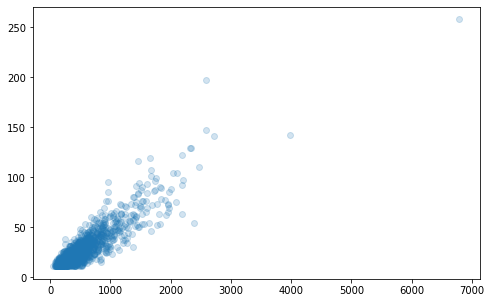

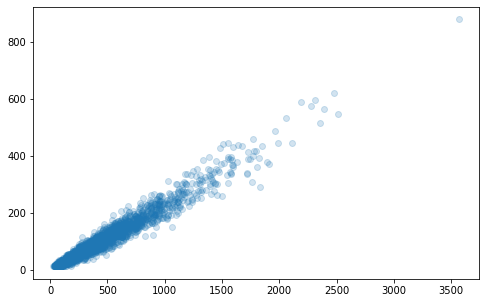

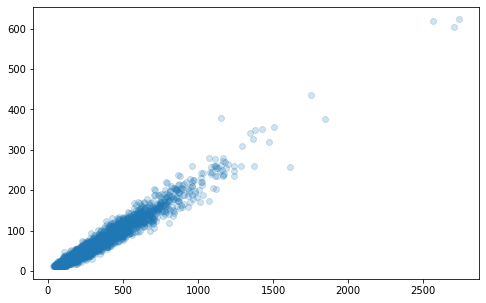

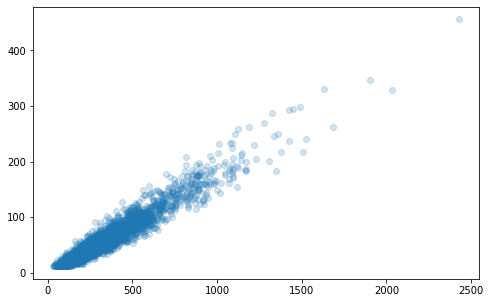

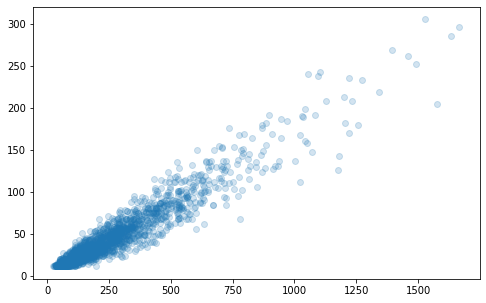

In [104]:
#separate data by measure name
#clean_data['Measure Name'].unique()
hipknee = clean_data[clean_data['Measure Name']=='READM-30-HIP-KNEE-HRRP']
heartfailure = clean_data[clean_data['Measure Name']=='READM-30-HF-HRRP']
copd = clean_data[clean_data['Measure Name']=='READM-30-COPD-HRRP']
pneumonia = clean_data[clean_data['Measure Name']=='READM-30-PN-HRRP']
heartattack = clean_data[clean_data['Measure Name']=='READM-30-AMI-HRRP']

measures = [hipknee, heartfailure, copd, pneumonia, heartattack]
for measure in measures:
    x = [a for a in measure['Number of Discharges']]
    y = list(measure['Number of Readmissions'])
    fig, ax = plt.subplots(figsize=(8,5))
    ax.scatter(x, y,alpha=0.2)

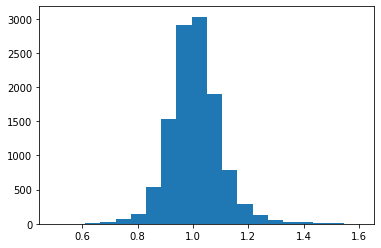

In [86]:
#draft histogram on the distribution of excess readmission ratios among hospitals
_ = plt.hist(clean_data['Excess Readmission Ratio'],range=(0.5,1.6),bins=20)
plt.show()


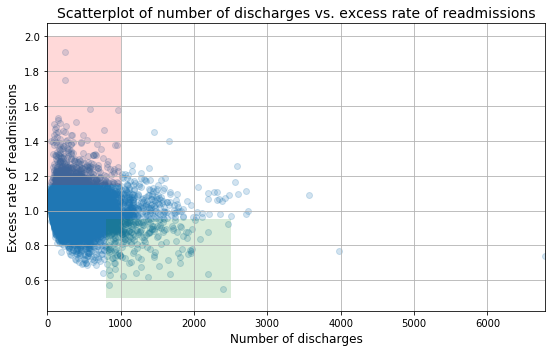

In [90]:
# generate a scatterplot for number of discharges vs. excess rate of readmissions
# lists work better with matplotlib scatterplot function
x = [a for a in clean_data['Number of Discharges']] #[81:-3]
y = list(clean_data['Excess Readmission Ratio']) #[81:-3]

fig, ax = plt.subplots(figsize=(8,5))
ax.scatter(x, y,alpha=0.2)

ax.fill_between([0,1000], 1.15, 2, facecolor='red', alpha = .15, interpolate=True)
ax.fill_between([800,2500], .5, .95, facecolor='green', alpha = .15, interpolate=True)

ax.set_xlim([0, max(x)])
ax.set_xlabel('Number of discharges', fontsize=12)
ax.set_ylabel('Excess rate of readmissions', fontsize=12)
ax.set_title('Scatterplot of number of discharges vs. excess rate of readmissions', fontsize=14)

ax.grid(True)
fig.tight_layout()

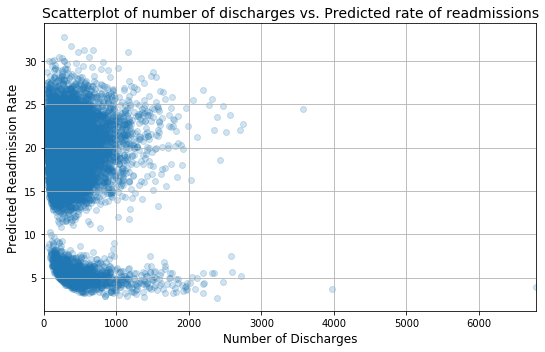

In [92]:
x = [a for a in clean_data['Number of Discharges']] #[81:-3]
y = list(clean_data['Predicted Readmission Rate']) #[81:-3]

fig, ax = plt.subplots(figsize=(8,5))
ax.scatter(x, y,alpha=0.2)

ax.set_xlim([0, max(x)])
ax.set_xlabel('Number of Discharges', fontsize=12)
ax.set_ylabel('Predicted Readmission Rate', fontsize=12)
ax.set_title('Scatterplot of number of discharges vs. Predicted rate of readmissions', fontsize=14)

ax.grid(True)
fig.tight_layout()

"""Scatterplot shows two distinct clusters, a small cluster with low predicted readmission dispite high number of discharges,
and the majority cluster which has higher predicted readmission rate independent of the number of discharges"""

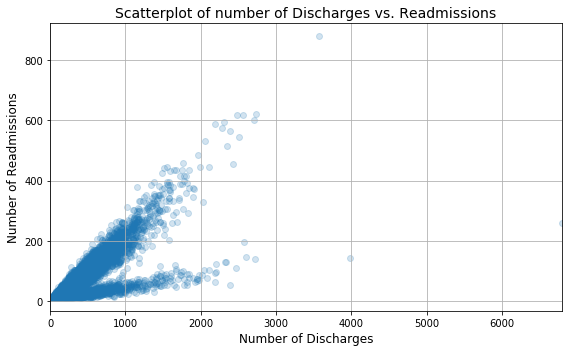

In [98]:
x = [a for a in clean_data['Number of Discharges']] #[81:-3]
y = list(clean_data['Number of Readmissions']) #[81:-3]

fig, ax = plt.subplots(figsize=(8,5))
ax.scatter(x, y,alpha=0.2)

ax.set_xlim([0, max(x)])
ax.set_xlabel('Number of Discharges', fontsize=12)
ax.set_ylabel('Number of Readmissions', fontsize=12)
ax.set_title('Scatterplot of Number of Discharges vs. Readmissions', fontsize=14)

ax.grid(True)
fig.tight_layout()
"""This scatterplot shows a similar pattern: one cluster of hospitals had low readmission numbers despite increase in number of discharges,
compared to the majority cluster that had steeper increases in readmissions based on number of discharges"""

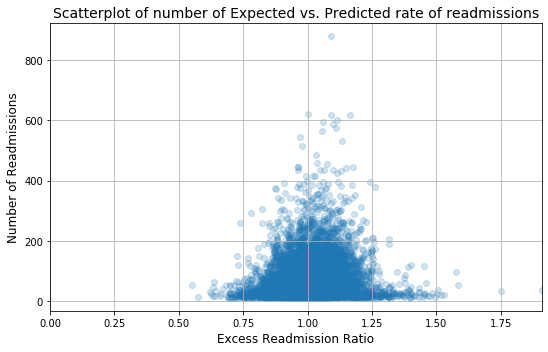

In [96]:
x = [a for a in clean_data['Excess Readmission Ratio']] #[81:-3]
y = list(clean_data['Number of Readmissions']) #[81:-3]

fig, ax = plt.subplots(figsize=(8,5))
ax.scatter(x, y,alpha=0.2)

ax.set_xlim([0, max(x)])
ax.set_xlabel('Excess Readmission Ratio', fontsize=12)
ax.set_ylabel('Number of Readmissions', fontsize=12)
ax.set_title('Scatterplot of number of Expected vs. Predicted rate of readmissions', fontsize=14)

ax.grid(True)
fig.tight_layout()

****

## Preliminary Report (In progress)

Read the following results/report. While you are reading it, think about if the conclusions are correct, incorrect, misleading or unfounded. Think about what you would change or what additional analyses you would perform.

**A. Initial observations based on the plot above**
+ A smaller number of discharges correlates to an increase in excess rate of readmissions

**B. Statistics**
+ In hospitals/facilities with number of discharges < 100, mean excess readmission rate is 1.023 and 63% have excess readmission rate greater than 1 
+ In hospitals/facilities with number of discharges > 1000, mean excess readmission rate is 0.978 and 44% have excess readmission rate greater than 1 

**C. Conclusions**
+ There is a significant correlation between hospital capacity (number of discharges) and readmission rates. 
+ Smaller hospitals/facilities may be lacking necessary resources to ensure quality care and prevent complications that lead to readmissions.

**D. Regulatory policy recommendations**
+ Hospitals/facilties with small capacity (< 300) should be required to demonstrate upgraded resource allocation for quality care to continue operation.
+ Directives and incentives should be provided for consolidation of hospitals and facilities to have a smaller number of them with higher capacity and number of discharges.